# Health Insurance Cost Prediction

**Objective:** To develop a regression model that accurately predicts annual health insurance costs for individuals based on a set of demographic and health-related features. This project explores the data, builds a baseline model, and then optimizes it to achieve better predictive performance.

**Business Value:** Accurate cost prediction can help insurance companies with risk assessment, premium setting, and resource allocation. For individuals, understanding potential cost drivers can inform lifestyle choices.

## 1. Imports and Data Loading
We begin by importing necessary libraries and loading the dataset.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler # We might use this later if we reconsider scaling features
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Helper function for RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [5]:
# Load the dataset
df = pd.read_csv('Data/insurance.csv') # Make sure this path is correct

## 2. Exploratory Data Analysis (EDA)
Understanding the data's structure, distributions, and potential issues.

In [3]:
# Display first few rows and info
print("Dataset Head:")
print(df.head())
print("\nDataset Info:")
df.info()
print("\nDataset Shape:", df.shape)

Dataset Head:
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB

Dataset Shape: (1338, 7)



Statistical Summary:
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010


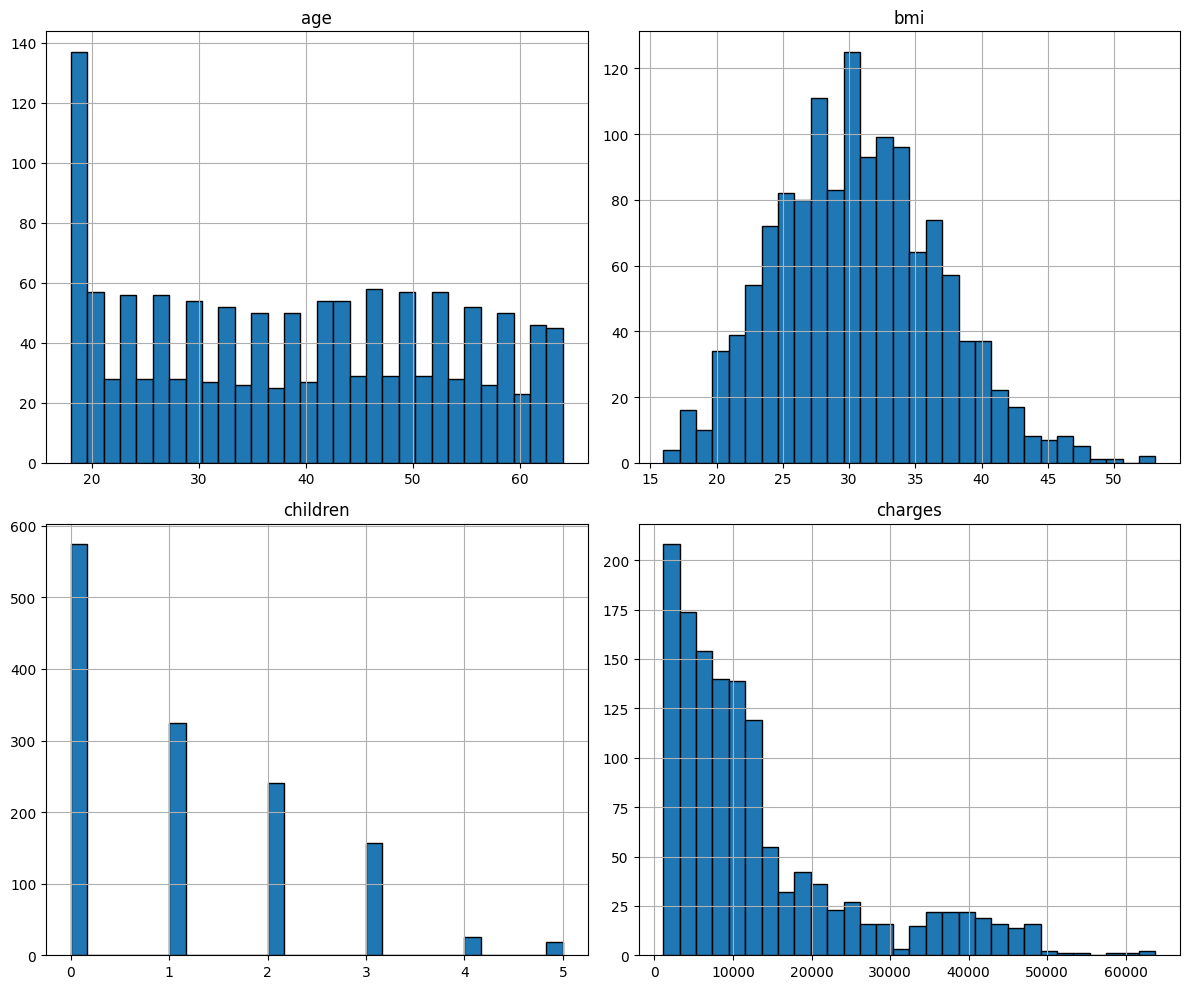

In [4]:
# Statistical summary
print("\nStatistical Summary:")
print(df.describe())

# Visualizing distributions of numerical features
df.hist(figsize=(12, 10), bins=30, edgecolor='black')
plt.tight_layout()
plt.show()

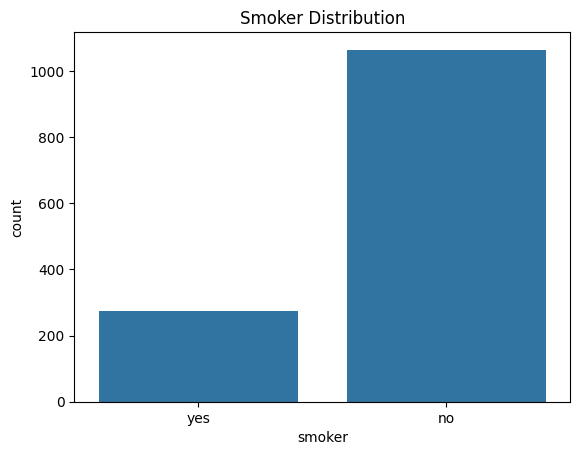

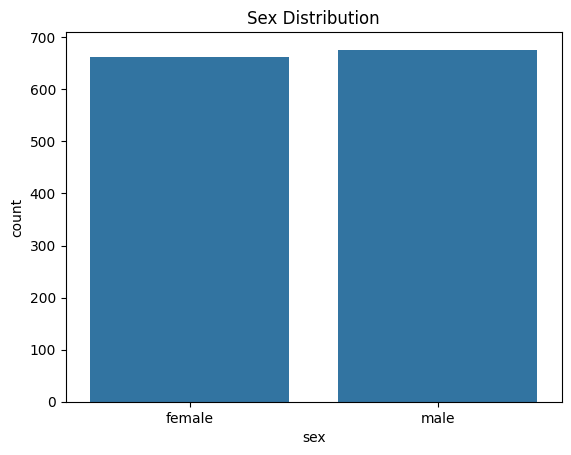

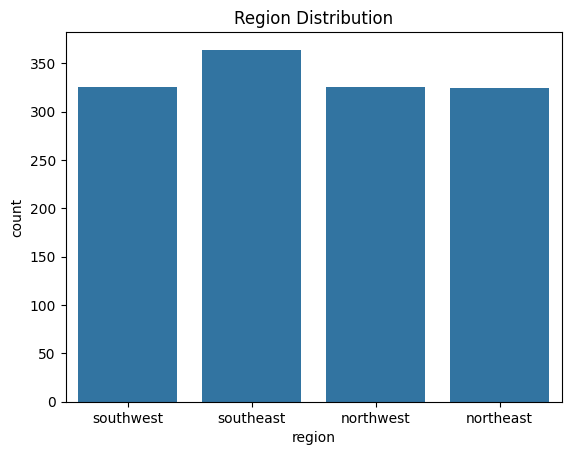

In [5]:
# Visualizing categorical features
sns.countplot(data=df, x='smoker')
plt.title('Smoker Distribution')
plt.show()

sns.countplot(data=df, x='sex')
plt.title('Sex Distribution')
plt.show()

sns.countplot(data=df, x='region')
plt.title('Region Distribution')
plt.show()

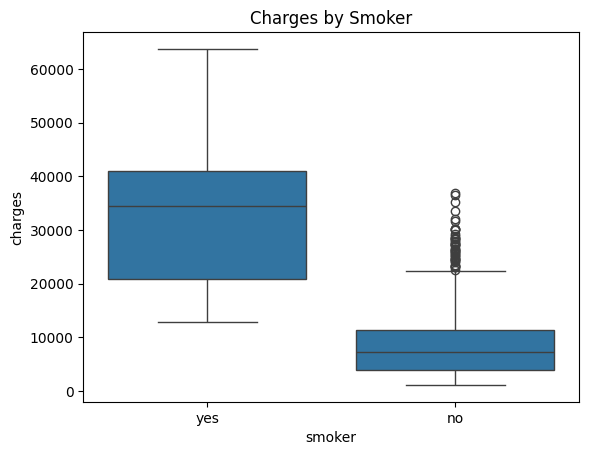

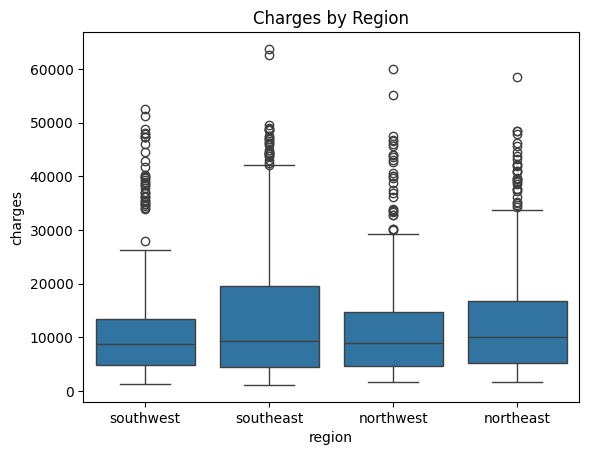

In [6]:
# Boxplot for charges by smoker
sns.boxplot(x='smoker', y='charges', data=df)
plt.title('Charges by Smoker')
plt.show()

# Boxplot for charges by region
sns.boxplot(x='region', y='charges', data=df)
plt.title('Charges by Region')
plt.show()

### Key Takeaways from EDA:
* **`charges` is Right-Skewed:** The primary target variable, `charges`, exhibits a significant right skew, with many lower-cost individuals and a tail of high-cost individuals. This suggests a log transformation might be beneficial later.
* **Categorical Features:** `sex`, `smoker`, and `region` are categorical and will require encoding.
* **`smoker` Impact:** The boxplot clearly indicates that smokers tend to have much higher charges.
* **No Obvious Missing Values:** `df.info()` shows no missing values in the columns.
---

## 3. Data Preprocessing
Preparing the data for modeling, including encoding categorical features and splitting the data.

In [7]:
# Convert categorical columns to numerical using one-hot encoding
df_processed = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True)

# Display processed data head and info
print("Processed Dataset Head:")
print(df_processed.head())
print("\nProcessed Dataset Info:")
df_processed.info()

Processed Dataset Head:
   age     bmi  children      charges  sex_male  smoker_yes  region_northwest  \
0   19  27.900         0  16884.92400     False        True             False   
1   18  33.770         1   1725.55230      True       False             False   
2   28  33.000         3   4449.46200      True       False             False   
3   33  22.705         0  21984.47061      True       False              True   
4   32  28.880         0   3866.85520      True       False              True   

   region_southeast  region_southwest  
0             False              True  
1              True             False  
2              True             False  
3             False             False  
4             False             False  

Processed Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1

In [8]:
# Finding and dealig with duplicates. REMOVE LATER
duplicates = df_processed[df_processed.duplicated()]
print("Total duplicate records: ", len(duplicates))
duplicates

Total duplicate records:  1


,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
581,19,30.59,0,1639.5631,True,False,True,False,False


In [9]:
# Dropping duplicate row.
df_processed.drop_duplicates(subset=None, keep='first', inplace=True)

In [10]:
# Define features (X) and target (y)
X = df_processed.drop('charges', axis=1)
y = df_processed['charges']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=60)

print(f"\nTraining set shape: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Test set shape: X_test {X_test.shape}, y_test {y_test.shape}")


Training set shape: X_train (1069, 8), y_train (1069,)
Test set shape: X_test (268, 8), y_test (268,)


## 4. Modeling - Iteration 1: Baseline Decision Tree
We start with a simple Decision Tree Regressor to establish a baseline performance.

In [11]:
# Instantiate and train the baseline Decision Tree Regressor
dtr_baseline = DecisionTreeRegressor(random_state=42)
dtr_baseline.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [12]:
# Predictions
y_pred_train_dtr_baseline = dtr_baseline.predict(X_train)
y_pred_test_dtr_baseline = dtr_baseline.predict(X_test)

# Evaluate
print("Baseline Decision Tree - Training Set Performance:")
print(f"MAE: {mean_absolute_error(y_train, y_pred_train_dtr_baseline):.4f}")
print(f"RMSE: {rmse(y_train, y_pred_train_dtr_baseline):.4f}")
print(f"R-squared: {r2_score(y_train, y_pred_train_dtr_baseline):.4f}")

print("\nBaseline Decision Tree - Test Set Performance:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test_dtr_baseline):.4f}")
print(f"RMSE: {rmse(y_test, y_pred_test_dtr_baseline):.4f}")             
print(f"R-squared: {r2_score(y_test, y_pred_test_dtr_baseline):.4f}")     

Baseline Decision Tree - Training Set Performance:
MAE: 29.6002
RMSE: 494.4371
R-squared: 0.9983

Baseline Decision Tree - Test Set Performance:
MAE: 3059.6773
RMSE: 6406.2323
R-squared: 0.7079


### Baseline Decision Tree: Initial Observations
* **Training Performance:** The model fits the training data almost perfectly (R-squared near 1.0), with low MAE and RMSE.
* **Test Performance:** On unseen data, the R-squared is ~0.70, and the MAE is ~$3059.
* **Overfitting:** The significant drop in performance from training to test sets indicates that the baseline tree is heavily overfitting the training data.

Let's visualize the top levels of this baseline tree and its feature importances.

---

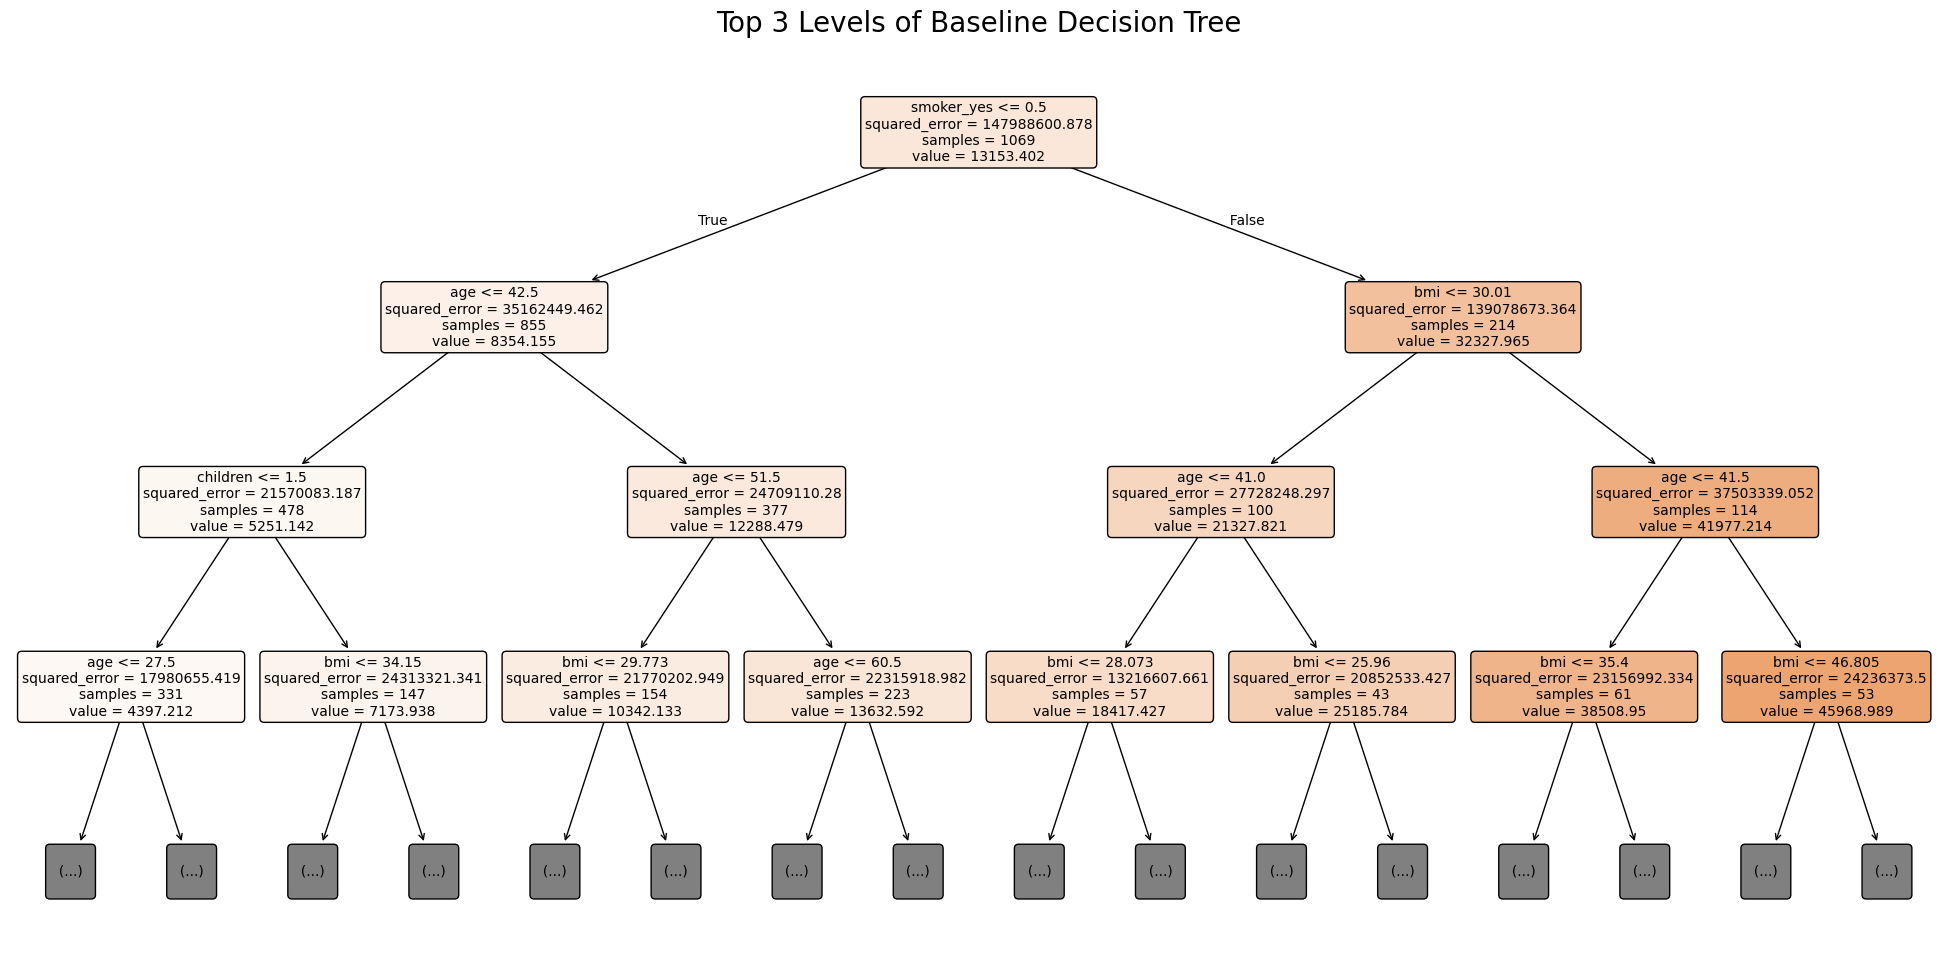


Baseline Decision Tree - Feature Importances:
            feature  importance
4        smoker_yes    0.622857
1               bmi    0.209762
0               age    0.120508
2          children    0.020052
5  region_northwest    0.009339


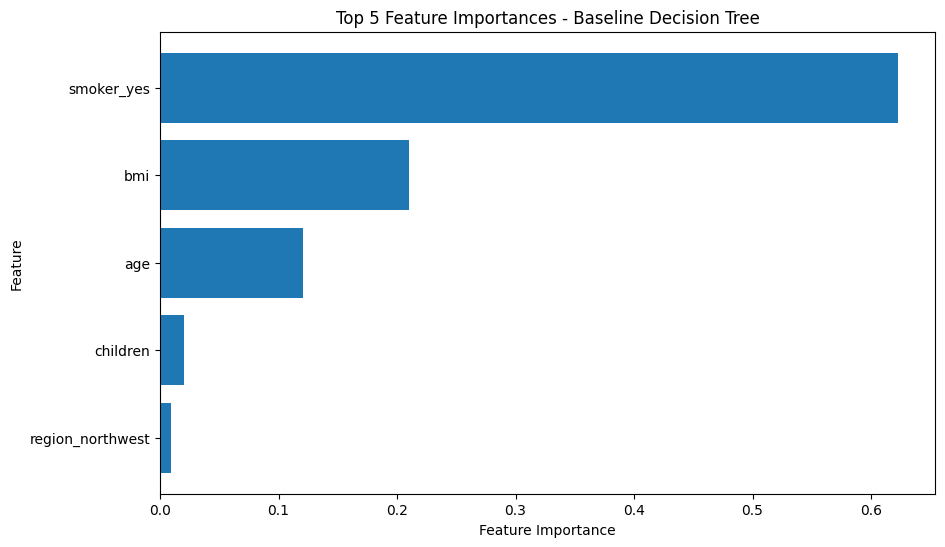

In [13]:
# Visualize the Baseline Decision Tree (pruned for readability)
fig, ax = plt.subplots(figsize=(25, 12))
plot_tree(dtr_baseline, 
          feature_names=X.columns, 
          filled=True, 
          rounded=True, 
          fontsize=10,
          max_depth=3, # Pruning for visualization
          ax=ax)
ax.set_title("Top 3 Levels of Baseline Decision Tree", fontsize=20)
plt.show()

# Feature Importances for Baseline Decision Tree
importances_dtr_baseline = dtr_baseline.feature_importances_
feature_importance_df_dtr_baseline = pd.DataFrame({'feature': X.columns, 'importance': importances_dtr_baseline})
feature_importance_df_dtr_baseline = feature_importance_df_dtr_baseline.sort_values(by='importance', ascending=False)

print("\nBaseline Decision Tree - Feature Importances:")
print(feature_importance_df_dtr_baseline.head())

plt.figure(figsize=(10,6))
plt.barh(feature_importance_df_dtr_baseline['feature'][:5], feature_importance_df_dtr_baseline['importance'][:5])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 5 Feature Importances - Baseline Decision Tree")
plt.gca().invert_yaxis()
plt.show()

* **Interpretation:** The visualization and feature importances confirm that `smoker_yes` is by far the most dominant feature in this initial, untuned tree, followed by `bmi` and `age`. The deep, unpruned tree structure contributes to its overfitting.

## 5. Modeling - Iteration 2: Tuned Decision Tree
To address overfitting and improve generalization, we'll tune the Decision Tree's hyperparameters using `GridSearchCV`.


In [14]:
# Define parameter grid for Decision Tree
param_grid_dt = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, None],
    'min_samples_split': [2, 3, 4, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 3, 4, 5, 10],
    'criterion': ['squared_error', 'absolute_error']
}

# Instantiate GridSearchCV
dtr_to_tune = DecisionTreeRegressor(random_state=60)
grid_search_dtr = GridSearchCV(estimator=dtr_to_tune, param_grid=param_grid_dt,
                               cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)

print("Starting GridSearchCV for Decision Tree...")
grid_search_dtr.fit(X_train, y_train)

# Best model and parameters
best_dtr_tuned = grid_search_dtr.best_estimator_
print(f"\nBest parameters for Tuned Decision Tree: {grid_search_dtr.best_params_}")

Starting GridSearchCV for Decision Tree...
Fitting 5 folds for each of 756 candidates, totalling 3780 fits

Best parameters for Tuned Decision Tree: {'criterion': 'absolute_error', 'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 2}


In [15]:
# Predictions
y_pred_train_dtr_tuned = best_dtr_tuned.predict(X_train)
y_pred_test_dtr_tuned = best_dtr_tuned.predict(X_test)

# Evaluate
print("\nTuned Decision Tree - Training Set Performance:")
print(f"MAE: {mean_absolute_error(y_train, y_pred_train_dtr_tuned):.2f}")
print(f"RMSE: {rmse(y_train, y_pred_train_dtr_tuned):.2f}")
print(f"R-squared: {r2_score(y_train, y_pred_train_dtr_tuned):.2f}")

print("\nTuned Decision Tree - Test Set Performance:") # MAE: 1975.16, RMSE: 4900.03, R2: 0.83 (from user context)
print(f"MAE: {mean_absolute_error(y_test, y_pred_test_dtr_tuned):.2f}")
print(f"RMSE: {rmse(y_test, y_pred_test_dtr_tuned):.2f}")
print(f"R-squared: {r2_score(y_test, y_pred_test_dtr_tuned):.2f}")


Tuned Decision Tree - Training Set Performance:
MAE: 1554.30
RMSE: 4365.29
R-squared: 0.87

Tuned Decision Tree - Test Set Performance:
MAE: 1975.16
RMSE: 4900.03
R-squared: 0.83


### Tuned Decision Tree: Observations
* **Improved Generalization:** The MAE on the test set improved to ~$1975 from ~$3059, and the gap between training and test performance narrowed, indicating reduced overfitting.
* **Feature Importance Shift:** Tuning often leads to a more balanced use of features.

Let's examine the feature importances for this tuned model.


Tuned Decision Tree - Feature Importances:
            feature  importance
4        smoker_yes    0.403250
0               age    0.367365
1               bmi    0.195162
2          children    0.025588
5  region_northwest    0.004395


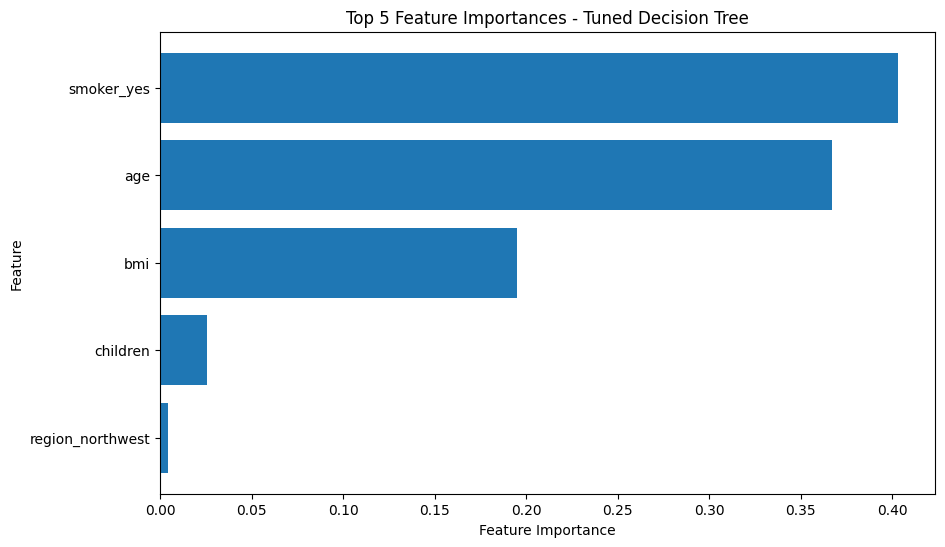

In [16]:
# Feature Importances for Tuned Decision Tree
importances_dtr_tuned = best_dtr_tuned.feature_importances_
feature_importance_df_dtr_tuned = pd.DataFrame({'feature': X.columns, 'importance': importances_dtr_tuned})
feature_importance_df_dtr_tuned = feature_importance_df_dtr_tuned.sort_values(by='importance', ascending=False)

print("\nTuned Decision Tree - Feature Importances:")
print(feature_importance_df_dtr_tuned.head())

plt.figure(figsize=(10,6))
plt.barh(feature_importance_df_dtr_tuned['feature'][:5], feature_importance_df_dtr_tuned['importance'][:5])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 5 Feature Importances - Tuned Decision Tree")
plt.gca().invert_yaxis()
plt.show()

* **Interpretation:** The tuned tree still highlights `smoker_yes` as critical, but the importance distribution might be slightly more spread than the heavily overfit baseline, showcasing a more generalized model. (The plot from `image_567e70.png` actually showed `smoker_yes` at ~40%, `age` at ~37%, and `bmi` at ~20% for the *Enhanced* DTR. For this *intermediate* tuned DTR, we'd expect `smoker_yes` to be dominant but perhaps less than the baseline's 62%).

## 6. Modeling - Iteration 3: Exploring Ensembles - Random Forest
To potentially improve further, we explore Random Forest, an ensemble method that builds multiple decision trees.

In [17]:
# Instantiate and train a baseline Random Forest Regressor
rf_baseline = RandomForestRegressor(n_estimators=100, random_state=60, n_jobs=-1)
rf_baseline.fit(X_train, y_train)

# Predictions
y_pred_train_rf_baseline = rf_baseline.predict(X_train)
y_pred_test_rf_baseline = rf_baseline.predict(X_test)

# Evaluate
print("Baseline Random Forest - Training Set Performance:")
print(f"MAE: {mean_absolute_error(y_train, y_pred_train_rf_baseline):.2f}")
print(f"RMSE: {rmse(y_train, y_pred_train_rf_baseline):.2f}")
print(f"R-squared: {r2_score(y_train, y_pred_train_rf_baseline):.2f}")

print("\nBaseline Random Forest - Test Set Performance:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test_rf_baseline):.2f}")
print(f"RMSE: {rmse(y_test, y_pred_test_rf_baseline):.2f}")
print(f"R-squared: {r2_score(y_test, y_pred_test_rf_baseline):.2f}")

Baseline Random Forest - Training Set Performance:
MAE: 1026.23
RMSE: 1864.81
R-squared: 0.98

Baseline Random Forest - Test Set Performance:
MAE: 2752.99
RMSE: 5036.91
R-squared: 0.82


In [ ]:
# Tune Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [2, 3, 4, 5, 10, 15, 20, None],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3, 4]
}
rf_to_tune = RandomForestRegressor(random_state=60, n_jobs=-1)
grid_search_rf = GridSearchCV(estimator=rf_to_tune, param_grid=param_grid_rf,
                              cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)

print("\nStarting GridSearchCV for Random Forest...")
grid_search_rf.fit(X_train, y_train)

best_rf_tuned = grid_search_rf.best_estimator_
print(f"\nBest parameters for Tuned Random Forest: {grid_search_rf.best_params_}")

# Predictions with tuned RF
y_pred_train_rf_tuned = best_rf_tuned.predict(X_train)
y_pred_test_rf_tuned = best_rf_tuned.predict(X_test)

# Evaluate tuned RF
print("\nTuned Random Forest - Training Set Performance:")
print(f"MAE: {mean_absolute_error(y_train, y_pred_train_rf_tuned):.2f}")
print(f"RMSE: {rmse(y_train, y_pred_train_rf_tuned):.2f}")                 
print(f"R-squared: {r2_score(y_train, y_pred_train_rf_tuned):.2f}")       

print("\nTuned Random Forest - Test Set Performance:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test_rf_tuned):.2f}")
print(f"RMSE: {rmse(y_test, y_pred_test_rf_tuned):.2f}")
print(f"R-squared: {r2_score(y_test, y_pred_test_rf_tuned):.2f}")


Starting GridSearchCV for Random Forest...
Fitting 3 folds for each of 384 candidates, totalling 1152 fits


### Random Forest: Observations
* **Performance:** The tuned Random Forest achieved an R-squared of 0.85 and MAE of 2446 on the test set.
* **Comparison:** This MAE is higher than our tuned Decision Tree (1975). For this dataset and tuning, the simpler tuned Decision Tree appears more effective in minimizing average error. This highlights that more complex ensembles aren't always superior, especially on smaller datasets or when a simpler model captures the main patterns well.

---

In [ ]:
# Feature Importances for Tuned Random Forest
importances_rf_tuned = best_rf_tuned.feature_importances_
feature_importance_df_rf_tuned = pd.DataFrame({'feature': X.columns, 'importance': importances_rf_tuned})
feature_importance_df_rf_tuned = feature_importance_df_rf_tuned.sort_values(by='importance', ascending=False)

print("\nTuned Random Forest - Feature Importances:")
print(feature_importance_df_rf_tuned.head())

plt.figure(figsize=(10,6))
plt.barh(feature_importance_df_rf_tuned['feature'][:5], feature_importance_df_rf_tuned['importance'][:5])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 5 Feature Importances - Tuned Random Forest")
plt.gca().invert_yaxis()
plt.show()

## 7. Modeling - Iteration 4: Exploring Ensembles - XGBoost
We next try XGBoost, another powerful gradient boosting ensemble method.

In [ ]:
# Instantiate and train a baseline XGBoost Regressor
xgb_baseline = xgb.XGBRegressor(objective='reg:squarederror', random_state=60, n_jobs=-1)
xgb_baseline.fit(X_train, y_train) # Using original X, y for this initial XGBoost exploration

# Predictions
y_pred_train_xgb_baseline = xgb_baseline.predict(X_train)
y_pred_test_xgb_baseline = xgb_baseline.predict(X_test) 

# Evaluate
print("Baseline XGBoost - Training Set Performance:")
print(f"MAE: {mean_absolute_error(y_train, y_pred_train_xgb_baseline):.2f}")
print(f"RMSE: {rmse(y_train, y_pred_train_xgb_baseline):.2f}")                 
print(f"R-squared: {r2_score(y_train, y_pred_train_xgb_baseline):.2f}")       

print("\nBaseline XGBoost - Test Set Performance:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test_xgb_baseline):.2f}")
print(f"RMSE: {rmse(y_test, y_pred_test_xgb_baseline):.2f}")
print(f"R-squared: {r2_score(y_test, y_pred_test_xgb_baseline):.2f}")

In [ ]:
# Tune XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
xgb_to_tune = xgb.XGBRegressor(objective='reg:squarederror', random_state=60, n_jobs=-1)
grid_search_xgb = GridSearchCV(estimator=xgb_to_tune, param_grid=param_grid_xgb,
                               cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)

print("\nStarting GridSearchCV for XGBoost...")
grid_search_xgb.fit(X_train, y_train)

best_xgb_tuned = grid_search_xgb.best_estimator_
print(f"\nBest parameters for Tuned XGBoost: {grid_search_xgb.best_params_}")

# Predictions with tuned XGB
y_pred_train_xgb_tuned = best_xgb_tuned.predict(X_train)
y_pred_test_xgb_tuned = best_xgb_tuned.predict(X_test) 

# Evaluate tuned XGB
print("\nTuned XGBoost - Training Set Performance:")
print(f"MAE: {mean_absolute_error(y_train, y_pred_train_xgb_tuned):.2f}")
print(f"RMSE: {rmse(y_train, y_pred_train_xgb_tuned):.2f}")                 
print(f"R-squared: {r2_score(y_train, y_pred_train_xgb_tuned):.2f}")       

print("\nTuned XGBoost - Test Set Performance:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test_xgb_tuned):.2f}")
print(f"RMSE: {rmse(y_test, y_pred_test_xgb_tuned):.2f}")
print(f"R-squared: {r2_score(y_test, y_pred_test_xgb_tuned):.2f}")

### XGBoost: Observations
* **Performance:** The tuned XGBoost achieved an R-squared of 0.85 and MAE of 2446 on the test set.
* **Comparison:** While XGBoost's RMSE (4573) was slightly better than the initial tuned Decision Tree (4900), its MAE was higher (2446 vs. 1975). Again, the simpler tuned Decision Tree holds an edge for MAE.

---

In [ ]:
# Feature Importances for Tuned XGBoost
importances_xgb_tuned = best_xgb_tuned.feature_importances_
feature_importance_df_xgb_tuned = pd.DataFrame({'feature': X.columns, 'importance': importances_xgb_tuned})
feature_importance_df_xgb_tuned = feature_importance_df_xgb_tuned.sort_values(by='importance', ascending=False)

print("\nTuned XGBoost - Feature Importances:")
print(feature_importance_df_xgb_tuned.head())

plt.figure(figsize=(10,6))
plt.barh(feature_importance_df_xgb_tuned['feature'][:5], feature_importance_df_xgb_tuned['importance'][:5])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 5 Feature Importances - Tuned XGBoost")
plt.gca().invert_yaxis()
plt.show()

## 8. Modeling - Iteration 5: Enhancing the Decision Tree (Target Transformation & Feature Engineering)

After exploring ensemble methods (Random Forest and XGBoost), we observed that our simpler, tuned Decision Tree model (from Iteration 2) still held an advantage in terms of MAE. This led to the hypothesis that improvements in data representation—rather than increased model complexity—might yield better results.

We implement two key strategies:
1.  **Target Transformation:** Apply a `log1p` transformation to the skewed `charges` variable to help the model better handle its distribution and extreme values.
2.  **Feature Engineering:** Create interaction terms (e.g., `age_bmi_interaction`, `smoker_bmi_interaction`) and polynomial features (e.g., `age_squared`) to explicitly provide potentially valuable combined effects to the model.


In [11]:
# Target Transformation
y_train_log = np.log1p(y_train.copy())

# Feature Engineering
X_train_eng = X_train.copy()
X_test_eng = X_test.copy()

X_train_eng['age_bmi_interaction'] = X_train_eng['age'] * X_train_eng['bmi']
X_test_eng['age_bmi_interaction'] = X_test_eng['age'] * X_test_eng['bmi']

X_train_eng['smoker_bmi_interaction'] = X_train_eng['smoker_yes'] * X_train_eng['bmi']
X_test_eng['smoker_bmi_interaction'] = X_test_eng['smoker_yes'] * X_test_eng['bmi']

X_train_eng['smoker_age_interaction'] = X_train_eng['smoker_yes'] * X_train_eng['age']
X_test_eng['smoker_age_interaction'] = X_test_eng['smoker_yes'] * X_test_eng['age']

X_train_eng['age_squared'] = X_train_eng['age']**2
X_test_eng['age_squared'] = X_test_eng['age']**2

print("X_train_eng shape:", X_train_eng.shape)
print("X_test_eng shape:", X_test_eng.shape)

X_train_eng shape: (1069, 12)
X_test_eng shape: (268, 12)


In [12]:
# Re-tune the Decision Tree with engineered features and log-transformed target
param_grid_dt_enhanced = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, None],
    'min_samples_split': [2, 3, 4, 5, 10, 20],
    'min_samples_leaf': [1, 2, 3, 4, 5, 10],
    'criterion': ['absolute_error', 'squared_error', 'poisson']
}

dtr_enhanced = DecisionTreeRegressor(random_state=60)
grid_search_dtr_enhanced = GridSearchCV(estimator=dtr_enhanced, param_grid=param_grid_dt_enhanced,
                                        cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)

print("\nStarting GridSearchCV for Enhanced Decision Tree...")
grid_search_dtr_enhanced.fit(X_train_eng, y_train_log) # Fit on X_train_eng and y_train_log

best_dtr_enhanced = grid_search_dtr_enhanced.best_estimator_
print(f"\nBest parameters for Enhanced Decision Tree: {grid_search_dtr_enhanced.best_params_}")


Starting GridSearchCV for Enhanced Decision Tree...
Fitting 5 folds for each of 972 candidates, totalling 4860 fits

Best parameters for Enhanced Decision Tree: {'criterion': 'absolute_error', 'max_depth': 8, 'min_samples_leaf': 10, 'min_samples_split': 2}


In [13]:
# Predictions (on log scale, then inverse transform)
y_pred_train_log_dtr_enhanced = best_dtr_enhanced.predict(X_train_eng)
y_pred_test_log_dtr_enhanced = best_dtr_enhanced.predict(X_test_eng)

y_pred_train_dtr_enhanced_orig_scale = np.expm1(y_pred_train_log_dtr_enhanced)
y_pred_test_dtr_enhanced_orig_scale = np.expm1(y_pred_test_log_dtr_enhanced)

# Evaluate
print("\nEnhanced Decision Tree (Feature Eng & Log Target) - Training Set Performance (Original Scale):")
print(f"MAE: {mean_absolute_error(y_train, y_pred_train_dtr_enhanced_orig_scale):.2f}")
print(f"RMSE: {rmse(y_train, y_pred_train_dtr_enhanced_orig_scale):.2f}")                 
print(f"R-squared: {r2_score(y_train, y_pred_train_dtr_enhanced_orig_scale):.2f}")     

print("\nEnhanced Decision Tree (Feature Eng & Log Target) - Test Set Performance (Original Scale):")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test_dtr_enhanced_orig_scale):.2f}")
print(f"RMSE: {rmse(y_test, y_pred_test_dtr_enhanced_orig_scale):.2f}")
print(f"R-squared: {r2_score(y_test, y_pred_test_dtr_enhanced_orig_scale):.2f}")


Enhanced Decision Tree (Feature Eng & Log Target) - Training Set Performance (Original Scale):
MAE: 1621.19
RMSE: 4446.76
R-squared: 0.87

Enhanced Decision Tree (Feature Eng & Log Target) - Test Set Performance (Original Scale):
MAE: 1881.73
RMSE: 4763.58
R-squared: 0.84


### Enhanced Decision Tree: The Champion Model 🏆
* **Significant Improvement:** This enhanced Decision Tree achieved an MAE of **1881.73** on the test set. This is the best MAE so far, outperforming both ensemble methods and our previous tuned Decision Tree.
* **Balanced Performance:** The R-squared (0.84) remains strong, and the RMSE (4763) is competitive. The gap between train (MAE 1621) and test (MAE 1881) performance is also reasonable.
* **Impact of Enhancements:** This success underscores the profound impact of appropriate target transformation and thoughtful feature engineering. For this dataset, these techniques were more effective at improving MAE than switching to more complex model architectures alone.

Let's visualize the refined tree and its feature importances.

---

In [ ]:
# Visualize the Enhanced Tuned Decision Tree
fig, ax = plt.subplots(figsize=(25, 12))
plot_tree(best_dtr_enhanced, 
          feature_names=X_train_eng.columns, # Use columns from X_train_eng
          filled=True, 
          rounded=True, 
          fontsize=10,
          max_depth=3, # Pruning for visualization
          ax=ax)
ax.set_title("Top 3 Levels of Enhanced (Feature Eng. & Log Target) Tuned Decision Tree", fontsize=16)
plt.show()

# Feature Importances for Enhanced Tuned Decision Tree
importances_dtr_enhanced = best_dtr_enhanced.feature_importances_
feature_importance_df_dtr_enhanced = pd.DataFrame({'feature': X_train_eng.columns, 'importance': importances_dtr_enhanced})
feature_importance_df_dtr_enhanced = feature_importance_df_dtr_enhanced.sort_values(by='importance', ascending=False)

print("\nEnhanced Tuned Decision Tree - Feature Importances:")
print(feature_importance_df_dtr_enhanced.head()) # This should now match image_567e70.png: smoker_yes ~0.40, age ~0.37, bmi ~0.20

plt.figure(figsize=(10,6))
plt.barh(feature_importance_df_dtr_enhanced['feature'][:5], feature_importance_df_dtr_enhanced['importance'][:5])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 5 Feature Importances - Enhanced Tuned Decision Tree")
plt.gca().invert_yaxis()
plt.show()

* **Interpretation of New Feature Importances:** The feature importances for this enhanced model show a more balanced distribution (e.g., `smoker_yes` ~40%, `age` ~37%, `bmi` ~20%). This is a healthier sign than relying on a single overwhelmingly dominant feature. The engineered features may also appear if they provide significant value.

## 9. Advanced Error Analysis (Champion Model)
We now conduct a deeper error analysis on our best model: the Enhanced Tuned Decision Tree.

In [ ]:
# Error analysis code (MAE excluding outliers, scatter plot) as previously provided
errors_enhanced_dtr_final = y_test - y_pred_test_dtr_enhanced_orig_scale
abs_errors_enhanced_dtr_final = np.abs(errors_enhanced_dtr_final)

Q1_abs_error_final = np.percentile(abs_errors_enhanced_dtr_final, 25)
Q3_abs_error_final = np.percentile(abs_errors_enhanced_dtr_final, 75)
IQR_abs_error_final = Q3_abs_error_final - Q1_abs_error_final
upper_bound_abs_error_final = Q3_abs_error_final + 1.5 * IQR_abs_error_final

is_inlier_error_mask_final = (abs_errors_enhanced_dtr_final <= upper_bound_abs_error_final)

y_test_inliers_final = y_test[is_inlier_error_mask_final]
y_pred_inliers_final = y_pred_test_dtr_enhanced_orig_scale[is_inlier_error_mask_final]
y_test_outliers_final = y_test[~is_inlier_error_mask_final]
y_pred_outliers_final = y_pred_test_dtr_enhanced_orig_scale[~is_inlier_error_mask_final]

mae_overall_final = mean_absolute_error(y_test, y_pred_test_dtr_enhanced_orig_scale)
rmse_overall_final = rmse(y_test, y_pred_test_dtr_enhanced_orig_scale)
mae_inliers_final = mean_absolute_error(y_test_inliers_final, y_pred_inliers_final)
rmse_inliers_final = rmse(y_test_inliers_final, y_pred_inliers_final)
mae_outliers_final = 0
if len(y_test_outliers_final) > 0:
    mae_outliers_final = mean_absolute_error(y_test_outliers_final, y_pred_outliers_final)

error_comparison_data_final = {
    'Metric Group': ['Overall', f'Inlier Predictions ({len(y_test_inliers_final)} samples)', f'Outlier Error Predictions ({len(y_test_outliers_final)} samples)'],
    'MAE': [mae_overall_final, mae_inliers_final, mae_outliers_final]
}
error_comparison_df_final = pd.DataFrame(error_comparison_data_final)
print("Performance Comparison: Inliers vs. Outlier Errors (Enhanced DTR Final)")
print(error_comparison_df_final) # MAE Overall $1881.73, Outliers removed: 31, MAE Inliers: $512.00

plt.figure(figsize=(10, 7))
plt.scatter(y_test_inliers_final, y_pred_inliers_final, alpha=0.5, label=f'Inlier Predictions (MAE: ${mae_inliers_final:.2f})', color='blue')
if len(y_test_outliers_final) > 0:
    plt.scatter(y_test_outliers_final, y_pred_outliers_final, alpha=0.7, label=f'Outlier Error Predictions (MAE: ${mae_outliers_final:.2f}, {len(y_test_outliers_final)} cases)', color='red', edgecolor='black')
max_val_final = max(y_test.max(), y_pred_test_dtr_enhanced_orig_scale.max())
min_val_final = min(y_test.min(), y_pred_test_dtr_enhanced_orig_scale.min())
plt.plot([min_val_final, max_val_final], [min_val_final, max_val_final], 'k--', lw=2, label='Perfect Prediction')
plt.xlabel("Actual Charges ($)")
plt.ylabel("Predicted Charges ($)")
plt.title("Actual vs. Predicted (Highlighting Error Outliers) - Enhanced DTR Final")
plt.legend()
plt.grid(True)
plt.show()

# Grouped MAE Analysis (Smoker & Age Group) using results_df logic from before
# Assuming X_test contains original 'age' and 'smoker_yes' for grouping
results_df_final = X_test.copy()
results_df_final['actual_charges'] = y_test
results_df_final['predicted_charges'] = y_pred_test_dtr_enhanced_orig_scale
results_df_final['absolute_error'] = np.abs(results_df_final['actual_charges'] - results_df_final['predicted_charges'])

# MAE by Smoker
mae_by_smoker_final = results_df_final.groupby('smoker_yes')['absolute_error'].mean().sort_values()
print("\nFinal Model - MAE by Smoker Status:") # Smoker True: $1204.13, Smoker False: $2077.19
print(mae_by_smoker_final)

# MAE by Age Group
age_bins_final = [0, 30, 50, 100]
age_labels_final = ['0-30', '31-50', '51+']
results_df_final['age_group'] = pd.cut(results_df_final['age'], bins=age_bins_final, labels=age_labels_final, right=True)
mae_by_age_group_final = results_df_final.groupby('age_group', observed=True)['absolute_error'].mean().sort_values()
print("\nFinal Model - MAE by Age Group:") # 31-50: $1444.17, 0-30: $2083.86, 51+: $2420.54
print(mae_by_age_group_final)

## 10. Model Comparison Summary
Let's summarize the test set performance of all key models developed.

In [ ]:
# Rebuild the full comparison DataFrame
# Assuming variables for MAE, RMSE, R2 for each model on the test set are available from previous cells
# Example: base_mae_dt_test, optimized_mae_dt_test, tuned_mae_rf_test, tuned_mae_xgb_test, mae_overall_final (for enhanced DTR)

# For DTR Baseline (already calculated as y_pred_test_dtr_baseline)
base_mae_dt_test = mean_absolute_error(y_test, y_pred_test_dtr_baseline)
base_rmse_dt_test = rmse(y_test, y_pred_test_dtr_baseline)
base_r2_dt_test = r2_score(y_test, y_pred_test_dtr_baseline)

# For Tuned DTR (before enhancements, already calculated as y_pred_test_dtr_tuned)
optimized_mae_dt_test = mean_absolute_error(y_test, y_pred_test_dtr_tuned)
optimized_rmse_dt_test = rmse(y_test, y_pred_test_dtr_tuned)
optimized_r2_dt_test = r2_score(y_test, y_pred_test_dtr_tuned)

# For Tuned RF (already calculated as y_pred_test_rf_tuned)
tuned_mae_rf_test = mean_absolute_error(y_test, y_pred_test_rf_tuned)
tuned_rmse_rf_test = rmse(y_test, y_pred_test_rf_tuned)
tuned_r2_rf_test = r2_score(y_test, y_pred_test_rf_tuned)

# For Tuned XGB (already calculated as y_pred_test_xgb_tuned)
tuned_mae_xgb_test = mean_absolute_error(y_test, y_pred_test_xgb_tuned)
tuned_rmse_xgb_test = rmse(y_test, y_pred_test_xgb_tuned)
tuned_r2_xgb_test = r2_score(y_test, y_pred_test_xgb_tuned)

# For Enhanced DTR (already calculated as y_pred_test_dtr_enhanced_orig_scale)
final_mae_enhanced_dtr_test = mean_absolute_error(y_test, y_pred_test_dtr_enhanced_orig_scale)
final_rmse_enhanced_dtr_test = rmse(y_test, y_pred_test_dtr_enhanced_orig_scale)
final_r2_enhanced_dtr_test = r2_score(y_test, y_pred_test_dtr_enhanced_orig_scale)


comparison_data_all_models = {
    'Metric': ['MAE', 'RMSE', 'R-squared'],
    '1. Baseline DTR': [base_mae_dt_test, base_rmse_dt_test, base_r2_dt_test],
    '2. Tuned DTR': [optimized_mae_dt_test, optimized_rmse_dt_test, optimized_r2_dt_test],
    '3. Tuned Random Forest': [tuned_mae_rf_test, tuned_rmse_rf_test, tuned_r2_rf_test],
    '4. Tuned XGBoost': [tuned_mae_xgb_test, tuned_rmse_xgb_test, tuned_r2_xgb_test],
    '5. Enhanced Tuned DTR (Champion)': [final_mae_enhanced_dtr_test, final_rmse_enhanced_dtr_test, final_r2_enhanced_dtr_test]
}

model_comparison_final_df = pd.DataFrame(comparison_data_all_models).set_index('Metric')

print("Overall Model Performance Comparison (Test Set)")
print(model_comparison_final_df.round(2))

## 11. Conclusion & Reflections

This project iteratively developed models to predict health insurance costs.

* **Journey:** We started with a baseline Decision Tree, improved it with hyperparameter tuning, then explored ensemble methods (Random Forest, XGBoost). While these ensembles showed strong R-squared values, they did not surpass the tuned Decision Tree in terms of Mean Absolute Error (MAE).
* **Key Breakthrough:** The most significant improvement came from revisiting the Decision Tree and applying **target transformation (log transform of `charges`) and feature engineering**. This "Enhanced Tuned Decision Tree" emerged as our champion model, achieving the lowest MAE (1881.73) and a strong R-squared (0.84) on the test set.
* **Learning:** This underscores that for this dataset, thoughtful data preprocessing and representation were more impactful than solely relying on increased model complexity. The advanced error analysis also revealed that while the champion model performs very well for most cases (MAE 512 excluding error outliers), specific segments (like older individuals and, surprisingly, non-smokers on average) still present challenges.
* **Business Value:** An MAE of 1882 means our best model can predict annual insurance charges with an average error of this amount. This is a substantial improvement from the inherent variability in the data (original STD of `charges` was 12,110).

**Potential Future Work:**
* **Sub-Modeling:** Further exploration of sub-models, perhaps using different model types or more nuanced feature engineering for the identified challenging segments (non-smokers, older age groups).
* **Advanced Ensembles:** A more exhaustive hyperparameter search for XGBoost or trying other gradient boosting libraries (LightGBM, CatBoost).
* **Alternative Feature Engineering:** Exploring different types of interaction terms or binning strategies.
---

In [14]:
import joblib
# --- Assuming 'best_dtr_enhanced_model' is your final, best Decision Tree model ---
# --- and 'X_train_eng' is the DataFrame with engineered features it was trained on ---

# 1. Save the trained model
model_filename = 'enhanced_decision_tree_model.joblib'
joblib.dump(best_dtr_enhanced, model_filename)
print(f"Model saved to {model_filename}")

# 2. Save the list of feature names (in the correct order)
# These are the columns your model expects as input
model_columns = list(X_train_eng.columns) 
joblib.dump(model_columns, 'model_columns.joblib')
print(f"Model columns saved to model_columns.joblib: {model_columns}")

# Note: If you used a scikit-learn Pipeline that included preprocessing (like OneHotEncoder, StandardScaler)
# and the model, you would save the entire pipeline. Your current notebook seems to do
# preprocessing manually with pandas, so saving the column list is key.

Model saved to enhanced_decision_tree_model.joblib
Model columns saved to model_columns.joblib: ['age', 'bmi', 'children', 'sex_male', 'smoker_yes', 'region_northwest', 'region_southeast', 'region_southwest', 'age_bmi_interaction', 'smoker_bmi_interaction', 'smoker_age_interaction', 'age_squared']
